<h1 style="font-size: 36px;">Constantin Gleyze</h1>

<p style="font-size: 30px;">
   Simulation of vanilla option deltas (Call - Put) for different strikes using the following methods:
</<ul style="list-style-type: none;">
    <li style="font-size: 25px;">Calculation via classic Monte Carlo</li>
    <li style="font-size: 25px;">Batch Method</li>
    <li style="font-size: 25px;">Practitioner's Method</li>
    <li style="font-size: 25px;">Adaptive Method</li>

<p></p>



The objective of this nano-project is to estimate the price of a vanilla option using several estimation methods within the framework of the Black-Scholes model. We denote the underlying price by $S_T^x$, whose dynamics under the risk-neutral probability $\mathbb{Q}$ are given by:
$$dS_t^x = S_t^x ( r dt + \sigma dW_t)$$
where $W_t$ is a Brownian motion under $\mathbb{Q}$, $r \geq 0$ is the risk-free rate, $\sigma > 0$ is the volatility, and $S_0^x = x > 0$ is the initial value of the underlying asset..


# <div style="font-size: 20px;">1. Creation of Our Base Functions and Methods</div>

 # <div style="font-size: 15px;">1.1. Base Functions </div>

In [23]:
#Importation of our main librairies we will use

import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import time
import pandas as pd
from IPython.display import display, HTML

We generate our space and initialisation for the creation of our random processes.

In [24]:
from numpy.random import default_rng, SeedSequence
sq = SeedSequence() #Seed initialization
rng = default_rng(sq) #Random sequence generation algorithm implementation


We create a function that enables us to generate brownian paths.

In [25]:
def brownian_simulation(paths : int, times : np.ndarray, increments : bool=False, rng: np.random.Generator = None) -> np.ndarray : 
    if rng is None : 
        rng = np.random.default_rng() #Create a seed and an subsequent algorithm if not provided

    #We sort the discretisation of our time and compute the lenght each time to detemrine the variance of our gaussian processes
    np.sort(times)
    time_lenght = np.diff(times).astype(np.float32)

    #We compute our points
    brownian_paths = (np.sqrt(time_lenght)*rng.standard_normal((paths, len(time_lenght)))).astype(np.float32)
    
    #Only return the increments between each points
    if increments : 
        return brownian_paths.ravel()
        
    #Return otherwise the trajectories of our brownian motion, necessiting the sum the increments from 0
    paths = np.hstack([np.zeros((paths,1)).astype(np.float32), np.cumsum(brownian_paths, axis=1)])
    
    return paths              

The dynamic of our underlying asset under the risk-neutral probability $\mathbb Q$ is : 

$$S_t = S_0e^{(r - \frac{\sigma^2}{2})t + \sigma W_t}$$

where $W_t$ is a Brownian motion under $\mathbb{Q}$, $r \geq 0$ is the risk-free rate, $\sigma > 0$ is the volatility, and $S_0^x = x > 0$ is the initial value of the underlying asset.


We therefore define a function to generate our underlying price at the time $T$, able to provide as well the same brownian we used to obtain our prices as it will be useful later. 

In [208]:
#Some of our methods require to generate two series of price in order to get a variance reduction
#Because we will need to generate to serie of prices from the same probability space, we add an option to choose one or two series of prices
#We may also need to return the brownian path generated in order to compute our option as the following closed formula for option prices will show 

def underlying_prices (S0, r, sigma, T,n, double_prices_series = False, brownian_constructor = False) : 
    brownian_paths = brownian_simulation(paths=n, times=np.array([0.0, T]), increments = True,rng=rng)

    #Because of the symmetry of the geometric brownian motion, we use the negative value of the generated brownian motion to generate our second prices' serie
    if double_prices_series : 
        S1 = S0*np.exp((r - 0.5*(sigma**2))*T + sigma*brownian_paths)
        brownian_paths = -brownian_paths
        S2 = S0*np.exp((r - 0.5*(sigma**2))*T + sigma*brownian_paths)
        if brownian_constructor : 
            return S1,S2,-brownian_paths
        else : 
            return S1,S2
    else : 
        S = S0*np.exp((r - 0.5*(sigma**2))*T + sigma*brownian_paths)
        if brownian_constructor : 
            return S, brownian_paths
        else : 
            return S

The payoff of the call option at $T$ is given by:

$$
\Pi_T^{\text{Call(T,K)}}(S_T^x) = (S_T^x-K)_+
$$

and that of the put option at $T$ given by : 

$$
\Pi_T^{\text{Put(T,K)}}(S_T^x) = (K-S_T^x)_+
$$

Their derivatives are the following : 

$$
\frac{d}{dS_T^{x}}(\Pi_T^{\text{Call(T,K)}}(S_T^x)) = \mathbf{1}_{\{S_T^x>=K\}}
$$

$$
\frac{d}{dS_T^{x}}(\Pi_T^{\text{Put(T,K)}}(S_T^x)) = -\mathbf{1}_{\{S_T^x<=K\}}
$$

We therefore define functions that reproduce these payoffs.



In [27]:
def payoff_call (S, K) : 
    return np.maximum(S-K,0)

def payoff_put (S, K) : 
    return np.maximum(K-S,0)

def derivative_payoff_call (S,K) : 
    return np.where(S > K, 1, 0)

def derivative_payoff_put(S,K) : 
    return np.where(K > S, -1, 0)

The price of a call at the time $t=0$ is given by the formula from Black & Scholes : 

$$C_0(T,K) = S_0\mathcal{N}(d_+) - Ke^{-rT}\mathcal{N}(d_-)$$

and the price of an equivalent put is 

$$P_0(T,K) = C_0(T,K) - S_0+ Ke^{-rT}$$

where $\mathcal{N}$ is the cumulative distribution function (CDF) of a standard normal random variable with:

$$d_+ = \frac{\log\left(\frac{x}{Ke^{-rT}}\right)+\frac{\sigma^2}{2}T}{\sigma\sqrt{T}}.$$

and

$$d_- = d_+ - {\sigma\sqrt{T}}$$

Using the closed formula of Black & Sholes prices for call and put option, we can also derive the delta, first derivative according to the underlying of our vanilla options: 

$$\frac{d}{dS_0}(C_0(T,K)) = \delta_0^{Call} =\mathcal{N}(d_+)$$
$$\frac{d}{dS_0}(P_0(T,K)) = \delta_0^{Put}=  \mathcal{N}(d_+)-1$$


We therefore define our functions to compute the exact theoric vanilla option's prices and deltas.

In [409]:
#Black Scholes closed formula
def call_price(S0, r, sigma, T, K,n) : 
    d1 = (np.log(S0/(K*np.exp(-r*T))) + (sigma**2)*(T/2))/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    call_price= S0*norm.cdf(d1) - K*(np.exp(-r*T))*norm.cdf(d2)
    return np.full(n, call_price).astype(np.float32)


#Using Call-Put parity
def put_price (S0, r, sigma, T, K,n) : 
    return call_price (S0, r, sigma, T, K,n)  -S0 + K*np.exp(-r*T)

def delta_call (S0, r, sigma, T, K) : 
    d1 = (np.log(S0/(K*np.exp(-r*T))) + (sigma**2)*(T/2))/(sigma*np.sqrt(T))
    return norm.cdf(d1)

#Using Call-Put parity
def delta_put (S0, r, sigma, T, K) : 
    return delta_call (S0, r, sigma, T, K) -1

Using the fact that the payoff functions of a call and a put option are borelian and polynomially increasing, we obtain the following result using Stein's lemma: 

$$\delta_0^{Call} = e^{-rT}\mathbb{E}\left[(S_T^x-K)_+\frac{W_T}{x\sigma T}\right]$$
$$\delta_0^{Put} = e^{-rT}\mathbb{E}\left[(K-S_T^x)_+\frac{W_T}{x\sigma T}\right]$$

We will call this quantity the brownian delta which we will try to estimate through a brownian_delta_estimator (b_d_e in the code).

Furthermore, using the fact that the payoff functions of a call and a put option are derivable and have a polynomial increasing derivative, we have the following result: 

$$\delta_0^{Call} = e^{-rT}\mathbb{E}\left[\frac{d}{dS_T^{x}}((S_T^x-K)_+)\frac{S_T^x}{x}\right]= e^{-rT}\mathbb{E}\left[\mathbb{1}_{\{S_T^x>=K\}}\frac{S_T^x}{x}\right]$$
$$\delta_0^{Put} = e^{-rT}\mathbb{E}\left[\frac{d}{dS_T^{x}}((K-S_T^x)_+)\frac{S_T^x}{x}\right] = e^{-rT}\mathbb{E}\left[-\mathbb{1}_{\{S_T^x<=K\}}\frac{S_T^x}{x}\right]$$

We will call this quantity the underlying delta which we will try to estimate through a underlying_delta_estimator (y_d_e in the code).

Therefore we obtain the following relationships : 

##### Call's delta closed formula is the following : 

$$\delta_0^{Call} = e^{-rT}\mathbb{E}\left[\mathbb{1}_{\{S_T^x>=K\}}\frac{S_T^x}{x}\right] = e^{-rT}\mathbb{E}\left[(S_T^x-K)_+\frac{W_T}{x\sigma T}\right]=\mathcal{N}(d_+)$$

##### Put's delta closed formula is the following : 

$$\delta_0^{Put} = e^{-rT}\mathbb{E}\left[-\mathbb{1}_{\{S_T^x<=K\}}\frac{S_T^x}{x}\right] = e^{-rT}\mathbb{E}\left[(K-S_T^x)_+\frac{W_T}{x\sigma T}\right]=\mathcal{N}(d_+)-1$$

We therefore have a closed formula for each delta and two expectations that we can approximate using our MC methods. 

We code our functions to determine our brownian_delta_estimator and underlying_delta_estimator.

In [412]:
#Once we are able to generate our prices and our brownian paths, we have to compute the estimate for each method, done through the following fonctions

def b_d_e_simulation (S0,S, W, K,T,sigma,r, payoff_function): 
    return np.exp(-r*T)*payoff_function(S,K)*W*(1/(T*S0*sigma))

def y_d_e_simulation (S0,S,W,K, T,sigma,r, payoff_function) : 
    S = S.astype(np.float32)
    return np.exp(-r*T)*payoff_function(S,K)*(S/S0)

During the description and implementation of each method, we will use the notation $X_k$ referring to the $k^{th}$ simulation of our option's delta. 

We assume the sequence $ (X_k)_{k=1}^n $ is i.i.d. for all  $n \geq 0$

# <div style="font-size: 20px;">The methods we will use </div>

 # <div style="font-size: 15px;">1.2. Classic Monte Carlo </div>

We first perform a "classic" Monte Carlo simulation, i.e., without modifying our estimator. This method has a high variance, which we will seek to reduce subsequently during this nano-project.

$$
\sqrt{n} \left( \overline{X}_n - m_X \right) \xrightarrow{\mathcal{L}} \mathcal{N}(0, \sigma_X^2) \quad \text{as } n \to +\infty,
$$

with 
$$
\overline{X_n} = \frac{1}{n}\sum_{k=1}^n{X_k} \quad \text{and} \quad m_X = \mathbb{E}[X_1] \quad \text{and} \quad \sigma_X^2 = \mathbb{V}[X_1],
$$

and therefore, if we define our error as:
$$
\epsilon_n = \overline{X}_n - m_X,
$$

we can derive that:
$$
\epsilon_n \xrightarrow{\mathcal{L}} \mathcal{N}\left(0, \frac{\sigma_X^2}{n}\right).
$$


In [53]:
def MC_option_simulation (S,serie=False,nb_simu=1000,var=False):

    #We can choose to return the cumulated MC to have a better idea of the convergence according to the number of simulations
    if serie : 

        #We extract a sub_set of several MC processes (number_simulations) to have an idea of the convergence of the serie
        #A first try, faster has been done with cumsum. However, the approximation done through the sum iterations resulted in false results with n > 1M
        #An approach using the single MC simulation price through a recursive approach, slower but more precise has therefore been chosen
        indices= np.linspace(0, len(S), nb_simu, dtype=int)
        serie = np.array([MC_option_simulation(S[:i],serie=False,nb_simu=nb_simu,var=var) for i in indices])   
        return serie 

    else: 

        #We can choose to return the variance of our error in addition to the MC price
        if var : 
            return np.mean(S),(len(S)/((len(S)-1))*((np.sum(S**2)/len(S)) - np.mean(S)**2))/len(S)
        else : 
            return np.mean(S)

 # <div style="font-size: 15px;">1.3. Batch approch  </div>

This approach uses the antithetic approach which aims to reduce the variance of our error and therefore improve the quality of the predictions.

We introduce a dynamic control variable $\lambda$ such that:

$$
X^{\lambda} = X - \lambda \Xi
$$

where $X$ and $X'$ follow the same distribution, i.e.

$$
\mathbb{E}[X] = \mathbb{E}[X'] = m_X, \quad \mathbb{V}[X] = \mathbb{V}[X'] = \sigma_X^2
$$

but with $\mathbb{V}[X - X'] > 0$, and $\Xi$ is defined as:

$$
\Xi = X - X'
$$

The variance of $X^{\lambda}$ is minimized when:

$$
\lambda_{\min} = \frac{\text{cov}(X, \Xi)}{\text{Var}[\Xi]}
$$

### Simulation Setup

The simulation is performed using:

$$
\overline{X}_n^\lambda = \frac{1}{n} \sum_{k=1}^n X_k^\lambda
$$

or equivalently:

$$
\overline{X}_n^\lambda = \overline{X}_n + \overline{\lambda}_n \overline{\Xi}_n
$$

where:

$$
\overline{\lambda}_n = \frac{\frac{1}{n} \sum_{k=1}^n X_k (X_k - X_k')}{\frac{1}{n} \sum_{k=1}^n (X_k - X_k')^2}
$$

and:

$$
\overline{\Xi}_n = \frac{1}{n} \sum_{k=1}^n (X_k - X_k')
$$

### Asymptotic Behavior

We have the asymptotic convergence:

$$
\sqrt{n} \left( \overline{X}_n^\lambda - m_X \right) \xrightarrow{\mathcal{L}} \mathcal{N}(0, \sigma_{\min}^2) \quad \text{as } n \to +\infty
$$

or equivalently:

$$
\left( \overline{X}_n^\lambda - m_X \right) \xrightarrow{\mathcal{L}} \mathcal{N}\left(0, \frac{\sigma_{\min}^2}{n}\right) \quad \text{as } n \to +\infty
$$
with : 

$$\sigma_{\min}^2 \leq \sigma_X^2$$



In [31]:
def Batch_approach (S1,S2,serie=False,nb_simu = 1000,parameters=False, var=False): 

    #Implementation of theta
    theta = S1-S2    

    #We can choose to return the cumulated MC to have a better idea of the convergence according to the number of simulations
    if serie : 

      if serie : 
        
        #We extract a sub_set of several MC processes (number_simulations) to have an idea of the convergence of the serie
        #A first try, faster has been done with cumsum. However, the approximation done through the sum iterations resulted in false results with n > 1M
        #An approach using the single MC simulation price through a recursive approach, slower but more precise has therefore been chosen
        indices= np.linspace(0, len(S1), nb_simu, dtype=int)
        serie = np.array([Batch_approach(S1[:i],S2[:i],serie=False,nb_simu = nb_simu,parameters=parameters, var=var) for i in indices])   
        return serie 

        if parameters: 
            return lambda1
        else : 
            return averaged_S1 - lambda1*averaged_theta
    else: 

        #Creation of our lambda Batch parameter we will use to compute the estimate price
        param_lambda = np.mean(S1*theta)/np.mean(theta**2)
        
        if parameters : 
            return param_lambda
        else : 

            #Computation of simulated payoff and theta mean for the Batch price, used whether the variance of the error is provided or not
            S1_mean = np.mean(S1)
            theta_mean = np.mean(S1-S2)
            
            #We can choose to return the variance of our error in addition to the MC price
            if var : 
                
                indices = np.arange(1, len(theta) + 1, dtype=np.float32)
                
                #Creation of our cumulated simulation theta square 2 average to compute our parameter lambda Batch 
                partial_theta_squared = theta**2
                cumulative_theta_squared = np.cumsum(partial_theta_squared)
                averaged_theta_squared = cumulative_theta_squared / indices

                #In order to avoid the division by 0, we create a security by remplacing 0 value by a very low value epsilon
                epsilon = 1e-10
                averaged_theta_squared = np.maximum(averaged_theta_squared, epsilon)

                #Creation of our parameter lambda Batch
                partial_lambda1 = S1 * theta
                cumulative_lambda1 = np.cumsum(partial_lambda1)
                averaged_lambda1 = cumulative_lambda1 / indices
                lambda1 = averaged_lambda1/averaged_theta_squared

                #Return of the Batch price and the variance of the error of the serie on which the average is computed
                return S1_mean - param_lambda*theta_mean, (len(S1)/(len(S1)-1))*((np.sum(((S1 - lambda1*theta)**2)/len(S1)) - np.mean(S1 - lambda1*theta)**2))/len(S1)
                
            else : 
                
                #Return solely of the Batch price
                return S1_mean - param_lambda*theta_mean

 # <div style="font-size: 15px;">1.4. Practitioner’s corner  </div>

However, in practice, we have the following relationship:

$$
\overline{X}_n^{\lambda_{\min}} = \overline{X}_n - \lambda_{\min} \overline{\Xi}_n
$$

Taking expectations on both sides, we get:

$$
\mathbb{E}[\overline{X}_n^{\lambda_{\min}}] = \mathbb{E}[\overline{X}_n] -  \mathbb{E}[\lambda_{\min} \overline{\Xi}_n]
$$

i.e,

$$
\mathbb{E}[\overline{X}_n^{\lambda_{\min}}] = m -  \mathbb{E}[\lambda_{\min} \overline{\Xi}_n]
$$

However, in practice, $\mathbb{E}[\lambda_{\min} \overline{\Xi}_n] \neq 0$.

To address this issue, we also calculate using what is called the "Practitioner's Corner":

We set \(n' < n\).

We simulate $(X_k, X_k')_{k=1}^{n'}$ and construct $\hat{\lambda}$ such that:

$$
\hat{\lambda}_{n'} = \frac{\frac{1}{n'} \sum_{k=1}^{n'} X_k (X_k - X_k')}{\frac{1}{n'} \sum_{k=1}^{n'} (X_k - X_k')^2}
$$

Then, we construct our estimator $\overline{X}_{n-n'+1}$:

$$
\overline{X}_{n-n'} = \frac{1}{n-n'} \sum_{k=n^{'}+1}^{n} X_k + \frac{\hat{\lambda}_{n'}}{n-n'} \sum_{k=n^{'}+1}^{n} \Xi_k
$$

We then have:

$$
\mathbb{E}[\overline{X}_{n-n'}^{\lambda_{\min}}] = m - \mathbb{E}[\hat{\lambda}_{n'} \overline{\Xi}_{n-n'}]
$$

or equivalently:

$$
\mathbb{E}[\overline{X}_{n-n'}^{\lambda_{\min}}] = m - \mathbb{E}[\hat{\lambda}_{n'}] \cdot \mathbb{E}[\overline{\Xi}_{n-n'}]
$$

With:

$$
\mathbb{E}[\overline{\Xi}_{n-n'}] = 0
$$

Thus, the estimator $\overline{X}_{n-n'}^{\lambda_{\min}}$ is unbiased. 



In [32]:
def Practitioner_corner (S1,S2,serie=False,nb_simu=1000, var = False): 
    
    #We can choose to return the cumulated MC to have a better idea of the convergence according to the number of simulations
    if serie :
        
        #We extract a sub_set of several MC processes (number_simulations) to have an idea of the convergence of the serie
        #A first try, faster has been done with cumsum. However, the approximation done through the sum iterations resulted in false results with n > 1M
        #An approach using the single MC simulation price through a recursive approach, slower but more precise has therefore been chosen
        indices= np.linspace(0, len(S1), nb_simu, dtype=int)
        serie = np.array([Practitioner_corner(S1[:i],S2[:i],serie=False,nb_simu=nb_simu, var = var) for i in indices])   
        return serie 
    
    else : 

        #We separate our total power of computation into a "training" set of lenght n_1 to approximation our lambda practitionner and on the "computation set" of lenght n_2 to compute our estimated price
        n_1 = int(np.floor(0.15*len(S1)))
        n_2 = len(S1) - n_1
    
        #Implementation of theta
        theta = S1-S2
        
        #Computation of our lambda practitionner on the "training set" of lenght n_1
        lambda_practionner = np.mean(S1[:n_1] * theta[:n_1]) / np.mean(theta[:n_1] ** 2)
    
        #Computation of simulated payoff and theta mean for the Batch price, used whether the variance of the error is provided or not
        S1_mean = np.mean(S1[n_1+1:])
        theta_mean = np.mean(theta[n_1+1:])

        #We can choose to return the variance of our error in addition to the MC price
        if var : 
            return S1_mean - lambda_practionner*theta_mean, (len(S1[n_1:])/(len(S1[n_1:])-1))*((np.sum(((S1[n_1:] - lambda_practionner*theta[n_1:])**2)/len(S1[n_1:])) - np.mean(S1[n_1:] - lambda_practionner*theta[n_1:])**2))/len(S1[n_1:])

        else : 

            #Return solely of the Practitioner price
            return S1_mean - lambda_practionner*theta_mean

# <div style="font-size: 15px;">1.5. Adaptative approach  </div>

Another approach exists, called the adaptive approach, to address this bias problem without splitting our effort, as done in the Practitioner's Corner.

We define : 

$$
\tilde{X}_k = X_k - \tilde{\lambda}_{k-1} \_k
$$

where:

$$
\tilde{\lambda}_{k} = \big((-k) \lor \lambda_k\big) \land k
$$

with $\lambda_k$ the parameter from our Batch approach. 

Our estimator is thereby computed as : 

$$
\overline{\tilde{X}}_n = \overline{X}_n - \frac{1}{n} \sum_{k=1}^{n} \tilde{\lambda}_{k-1} \Xi_k
$$

or : 

$$
\overline{\tilde{X}}_n = \overline{X}_n - \tilde{\lambda}_{k-1} \overline{\Xi}_k
$$


In [33]:
def Adaptative_approach (S1,S2,serie=False, nb_simu = 1000, var=False): 

    #Implementation of theta
    theta = S1-S2


    #We can choose to return the cumulated MC to have a better idea of the convergence according to the number of simulations
    if serie :
        
        #We extract a sub_set of several MC processes (number_simulations) to have an idea of the convergence of the serie
        #A first try, faster has been done with cumsum. However, the approximation done through the sum iterations resulted in false results with n > 1M
        #An approach using the single MC simulation price through a recursive approach, slower but more precise has therefore been chosen
        indices= np.linspace(0, len(S1), nb_simu, dtype=int)
        serie = np.array([Adaptative_approach(S1[:i],S2[:i],serie=False, nb_simu = nb_simu, var=var) for i in indices])   
        return serie 
     
    else : 

        #Computation of simulated payoff and theta mean for the Adapative price as well as our lambda parameter, used whether the variance of the error is provided or not
        S1_mean = np.mean(S1)
        theta_mean = np.mean(S1-S2)
        lambda_adaptative_one_price = min(max((np.mean((S1[:-1] * theta[:-1]))/np.mean((theta[:-1] ** 2))),-(len(S1)-1)),len(S1)-1)

        #We can choose to return the variance of our error in addition to the MC price
        if var : 
            
            indices = np.arange(1, len(theta) + 1, dtype=np.float32)
            #Creation of our cumulated simulation theta square 2 average to compute our parameter lambda Batch 
            partial_theta_squared = theta**2
            cumulative_theta_squared = np.cumsum(partial_theta_squared)
            averaged_theta_squared = cumulative_theta_squared / indices

            #In order to avoid the division by 0, we create a security by remplacing 0 value by a very low value epsilon
            epsilon = 1e-10
            averaged_theta_squared = np.maximum(averaged_theta_squared, epsilon)

            #Creation of our cumulated lambda Batch
            partial_lambda1 = S1 * theta
            cumulative_lambda1 = np.cumsum(partial_lambda1)
            averaged_lambda1 = cumulative_lambda1 /indices
            lambda1 = averaged_lambda1/averaged_theta_squared
            
            #From the Batch parameter, we apply the formula for the adaptative parameter 
            lambda_adaptative_no_shifted= np.maximum(-indices, np.minimum(lambda1,indices))
            
            #We shift our lambda from one to the left to well multiply by lambda_k_-1 to keep the shift recurrence relationship
            lambda_adaptative = np.concatenate(([0], lambda_adaptative_no_shifted[:-1]))
            
            #Return of the Adaptative price and the variance of the error of the serie on which the average is computed
            return S1_mean - lambda_adaptative_one_price*theta_mean, (len(S1)/(len(S1)-1))*((np.sum(((S1 - lambda1*theta)**2)/len(S1)) - np.mean(S1 - lambda1*theta)**2))/len(S1)
            
        else : 

            #Return solely of the Adaptative price
            return S1_mean - lambda_adaptative_one_price*theta_mean

# <div style="font-size: 20px;">2. Functions to display results</div>

# <div style="font-size: 15px;">2.1. Function to display a panda dataframe of our results</div>

In [416]:
#Function to display the results according to the number of simulations as well as our variance
def print_results_panda (S0,r, T, K, sigma, estimator_function, prix_option, payoff_function, n_values, series = False,title="") : 
    

    beginning = time.time()

    #We comute our prices
    S1, S2,W = underlying_prices (S0, r, sigma, T,max(n_values), double_prices_series = True, brownian_constructor = True)
    S1 = S1.astype(np.float32)
    S2 = S2.astype(np.float32)
    W = W.astype(np.float32)


    #We compute only once our estimates for each estimator and method 
    S1_complete = [[] for i in range(len(estimator_function))]
    S2_complete = [[] for i in range(len(estimator_function))]
    index = 0
    for estimator in estimator_function : 
        for f in payoff_function[index] : 
            S1_complete[index].append(estimator(S0,S1,W,K,T,sigma,r,f) )
            S2_complete[index].append(estimator(S0,S2,-W,K,T,sigma,r,f))
           
        index+=1
 
    end = time.time()
    execution_time = end - beginning

    #We time in order to have an idea which routine takes the more time to execute
    print(f"Time to generate {max(n_values):,} prices and {max(n_values)*len(estimator_function)*len(payoff_function):,} associated payoffs : {execution_time:.2f} seconds")
        
    for j in range (len(prix_option)) : 
        
        BS_price = prix_option[j] (S0, r, sigma, T, K)

        #We prepare our numpy to stock our data
        errors_mc = np.array([])
        errors_batch = np.array([])
        errors_practitioner = np.array([])
        errors_adaptative = np.array([]) 
        
        vars_mc = np.array([])
        vars_batch = np.array([])
        vars_practitioner = np.array([])
        vars_adaptative = np.array([]) 

        nb_simu =np.array([]) 
        estimator_name = np.array([])

        times = np.array([]) 
        
        for n in n_values :
            for i in range (len(estimator_function)):

                S1 = np.asarray(S1_complete[i][j][:n])
                S2 = np.asarray(S2_complete[i][j][:n])

                #For each estimator and method, we compute the price, the variance and we store the error relative to the BS price and the var

                beginning = time.time()
                
                #Classic Monte Carlo method
                mc_price,var_mc = MC_option_simulation (S1,serie=series, var=True)
                errors_mc = np.append(errors_mc, np.abs(mc_price - BS_price))
                vars_mc = np.append(vars_mc,var_mc)
        
                #Batch method
                batch_price,var_batch =  Batch_approach (S1,S2,serie=series, var=True)
                errors_batch =  np.append(errors_batch, np.abs(batch_price - BS_price))
                vars_batch = np.append(vars_batch,var_batch)
        
                #Practitioner method
                practitioner_price,var_practitioner =  Practitioner_corner (S1,S2,serie=series, var=True)
                errors_practitioner =  np.append(errors_practitioner, np.abs(practitioner_price - BS_price))
                vars_practitioner = np.append(vars_practitioner,var_practitioner)
        
                #Adaptative method
                adaptative_price,var_adaptative =  Adaptative_approach (S1,S2, serie=series,var=True)
                errors_adaptative =  np.append(errors_adaptative, np.abs(adaptative_price - BS_price))
                vars_adaptative = np.append(vars_adaptative,var_adaptative)

                nb_simu = np.append(nb_simu,n)
            
                estimator_name = np.append(estimator_name,''.join(estimator_function[i].__name__.split('_')[:3]).upper())

                #We compute our execution time 
                end = time.time() 
                execution_time = end - beginning
                times = np.append(times,round(execution_time,4))

            #We are alos interested by comparing the two estimators between them. Therefore we compute the ratio
            if len(estimator_function)==2 : 
                idx_numerator = -2
                idx_denominator = -1
                errors_mc = np.append(errors_mc, round(errors_mc[idx_numerator] / errors_mc[idx_denominator],4))
                vars_mc = np.append(vars_mc,round(vars_mc[idx_numerator] / vars_mc[idx_denominator],4))
                
                errors_batch =  np.append(errors_batch, round(errors_batch[idx_numerator] / errors_batch[idx_denominator],4))
                vars_batch = np.append(vars_batch,round(vars_batch[idx_numerator] / vars_batch[idx_denominator],4))

                errors_practitioner =  np.append(errors_practitioner, round(errors_practitioner[idx_numerator] / errors_practitioner[idx_denominator],4))
                vars_practitioner = np.append(vars_practitioner,round(vars_practitioner[idx_numerator] / vars_practitioner[idx_denominator],4))

                errors_adaptative =  np.append(errors_adaptative, round(errors_adaptative[idx_numerator] / errors_adaptative[idx_denominator],4))
                vars_adaptative = np.append(vars_adaptative,round(vars_adaptative[idx_numerator] / vars_adaptative[idx_denominator],4))

                times = np.append(times,"")
                nb_simu = np.append(nb_simu,n)
                estimator_name = np.append(estimator_name,estimator_name[idx_numerator] + " \ " +  estimator_name[idx_denominator])

        #Creation of our DataFrame to display the results
        results = pd.DataFrame({
            'Nb simulation': [f"{x:,}" for x in nb_simu],
            'Estimator' : estimator_name,
            'Time computation 4 estimators':times,
            'Error Classic MC': errors_mc,
            'Error Batch approach' : errors_batch,
            'Error Practionner approach' : errors_practitioner,
            'Error Adaptative approach' : errors_adaptative,
            'Var error Classic MC ': [f"{float(x):.6e}" if x != "" else "" for x in vars_mc],
            'Var error Batch approach ': [f"{float(x):.6e}" if x != "" else "" for x in vars_batch],
            'Var error Practionner approach ': [f"{float(x):.6e}" if x != "" else "" for x in vars_practitioner],
            'Var error MC Adaptative approach': [f"{float(x):.6e}" if x != "" else "" for x in vars_adaptative]})

        #We groupe the line of Number simulation that are equal
        results['Nb simulation'] = results['Nb simulation'].mask(results['Nb simulation'].duplicated(), '')

    
        #To add and align to the center a title to our dataframe, we use html
        html_template = f"""
        <div style="display: flex; flex-direction: column; align-items: center;">
            <div style="text-align: center; font-size: 20px; font-weight: bold; margin-bottom: 10px;">
                {title[j]}
            </div>
            {results.to_html(index=False)}
        </div>
        """
        
        display(HTML(html_template))

# <div style="font-size: 15px;">2.2. Function to display and analyse our error's convergence speed to 0 according to the number of simulation </div>

In [418]:
#This sub function has for goal to compute our errors to feed the plot function below
def generate_data_convergence_error_according_to_n (K,S1,S2,BS_price,option_type,estimator_function, nb_simu_wanted) : 

    #We compute our prices
    
    mc_price = MC_option_simulation (S1,serie=True, nb_simu = nb_simu_wanted)
    error_mc = np.abs(mc_price-BS_price)
    
    batch_price =  Batch_approach (S1,S2,serie=True,nb_simu = nb_simu_wanted)
    batch_errors = np.abs(batch_price-BS_price)

    practitioner_price =  Practitioner_corner (S1,S2,serie=True,nb_simu = nb_simu_wanted)
    practitioner_errors = np.abs(practitioner_price-BS_price)
   
    adaptative_price =  Adaptative_approach (S1,S2,serie=True,nb_simu = nb_simu_wanted)
    adaptative_errors = np.abs(adaptative_price-BS_price)

    #We convert our numpy into list, which would make it easier to plot through matplotlib
    data = [arr for arr in [error_mc, batch_errors, practitioner_errors, adaptative_errors]]
    data = [[f"{option_type.__name__.replace('_', ' ').title()}",K,''.join(estimator_function.__name__.split('_')[:3]).upper()]]+data
    
    return data

#This function will plot a sample of MC methods between 0 and the number of simulation given to show the speed of convergence
#To have a referential, the CV rate of 1 / sqrt(nb simulations) is also plot
#We can decide the number of points we want to generate 
#Classic plot function that can dynamically adapt itself according to the number of "set of data" we give to it 
#It will do as many graphs as "set of data" are given, two maximum per rows
def print_data_convergence_error_according_to_n (S0,r,sigma,T,K,n, estimator_function,option_type, payoff_function, nb_simu_wanted = 1000, zoom = 0) : 
    
    datas = []

    #We simulate our prices
    beginning1 = time.time() 
    S1, S2,W1 = underlying_prices (S0, r, sigma, T,n, double_prices_series = True, brownian_constructor = True)
    S1 = S1.astype(np.float32)
    S2 = S2.astype(np.float32)
    W1= W1.astype(np.float32)
    W2 = -W1
    end1 = time.time()
    execution_time1 = end1 - beginning1

    # Computation of errors
    beginning2 = time.time()

    for K_i in K : 
        for i in range(len(option_type)) : 
            data = []
            for j in range(len(estimator_function)) : 
                
                #We compute our actualized payoff simulations according to the payoff function asked 
                #We can not do it for all at the beginning because of the different strikes we are looking at
                S1_bis = estimator_function[j](S0,S1,W1,K_i,T,sigma,r,payoff_function[j][i]) 
                S2_bis = estimator_function[j](S0,S2,W2,K_i,T,sigma,r,payoff_function[j][i])
                
                #We compute our reference value through the closed formula of Black Sholes 
                BS_price = prix_option[i] (S0, r, sigma, T, K_i)

                #We generate our errors series to plot according to each type of option we want to display
                #To have a fast but less precise result, we can compute only few nb_simu_wanted or in the contrary increase it
                data.append(generate_data_convergence_error_according_to_n (K_i,S1_bis,S2_bis,BS_price,option_type[i],estimator_function[j],nb_simu_wanted))
            datas.append(data)

    end2 = time.time() 
    execution_time2 = end2 - beginning2

    #Adapt dynamically the number of plot to be done with 2 plots per row 
    num_graphs = len(datas) 
    num_cols = 2                 
    num_rows = (num_graphs + 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, num_rows * 5))
    axes = axes.ravel()

    #We plot our data and we time it also (this is the main aspect of the function that takes time)
    beginning3 = time.time() 

    #We introduce a zoom option to have a closer look of the convergence. 
    #Indeed, the CV is very fast near to 0 and becomes slower after, making the graphics unadapted
    #If zoom is 15%, we exclude the 15% first values
    #If the user wants to zoom, this part adjusts consequently the absice axis
    zoom_index = int(zoom*nb_simu_wanted)
    n_values = np.linspace(0, len(S1), nb_simu_wanted, dtype=int)
    n_values_zoomed = n_values[zoom_index:]
    n_values_sqrt = n_values_zoomed
    if zoom ==0 : n_values_sqrt[0]=1
    inverse_sqrt_n_values = 1 / np.sqrt(n_values_sqrt)

    for idx, dataset in enumerate(datas):
        ax = axes[idx]
        plot_data = [
            
            # Stock our data and label to plot
            {"data": dataset[0][1][zoom_index:], "label": f"{dataset[0][0][2]} Monte Carlo Simulation", "color": "lightskyblue"},
            {"data": dataset[0][2][zoom_index:], "label": f"{dataset[0][0][2]} Batch Method", "color": "cornflowerblue"},
            {"data": dataset[0][3][zoom_index:], "label":  f"{dataset[0][0][2]} Practitioner Method", "color": "royalblue"},
            {"data": dataset[0][4][zoom_index:], "label":  f"{dataset[0][0][2]} Adaptive Method", "color": "navy"},

            {"data": dataset[1][1][zoom_index:], "label":  f"{dataset[1][0][2]} Monte Carlo Simulation", "color": "lightcoral"},
            {"data": dataset[1][2][zoom_index:], "label": f"{dataset[1][0][2]} Batch Method", "color": "indianred"},
            {"data": dataset[1][3][zoom_index:], "label": f"{dataset[1][0][2]} Practitioner Method", "color": "firebrick"},
            {"data": dataset[1][4][zoom_index:], "label": f"{dataset[1][0][2]} Adaptive Method", "color": "darkred"},
            
            # CV reference 1 / sqrt(n)
            {"data": inverse_sqrt_n_values, "label": r"$\frac{1}{\sqrt{n}}$", "color": "black", "linestyle": "--"}]

        # Plot
        for entry in plot_data:
            ax.plot(
                n_values_zoomed,
                entry["data"],  
                '-',
                label=entry["label"],
                color=entry["color"]
            )

        #Do the legend of our graphes
        ax.set_title(f"{dataset[0][0][0]} pricing error according to the numbers \n of simulations with K = {dataset[0][0][1]}", fontsize=10 )
        ax.set_xlabel("Number of simulations (n)")
        ax.set_ylabel(f"{dataset[0][0]} pricing error")
        ax.legend()
        ax.grid(True)

    # Delete unused axis
    for idx in range(len(datas), len(axes)):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.show()

    end3 = time.time() 
    execution_time3 = end3 - beginning3

    #Print results of time execution
    print(f"Time {n:,} prices generation: {execution_time1:.2f} seconds")
    print(f"Time computation estimators series for each K and each payoff function: {execution_time2:.2f} seconds")
    print(f"Time plot : {execution_time3:.2f} seconds")

# <div style="font-size: 15px;">2.3. Function to display our approximation error for several strikes and number of simulation </div>

In [420]:
#To change a little, we do our plot function as a sub function
#Classic plot function
def graphe_result(strikes, prices, n,option_type): 
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    #Figure to plot our approximation of the price (ax1) and the error with the BS price (ax2)
    
    ax1.plot(strikes, prices[1], '-', color ='Black', label='Black-Scholes')
    ax1.plot(strikes, prices[2], '-', color ='lightskyblue', label=f"{prices[0][0]} Monte Carlo Simulation")
    ax1.plot(strikes, prices[3], '-', color ='cornflowerblue', label= f"{prices[0][0]} Batch Method")
    ax1.plot(strikes, prices[4], '-', color ='royalblue', label=f"{prices[0][0]} Practitioner Method")
    ax1.plot(strikes, prices[5], '-', color ='navy', label=f"{prices[0][0]} Adaptive Method")
    ax1.plot(strikes, prices[6], '-', color ='lightcoral', label=f"{prices[0][1]} Monte Carlo Simulation")
    ax1.plot(strikes, prices[7], '-', color ='indianred', label= f"{prices[0][1]} Batch Method")
    ax1.plot(strikes, prices[8], '-', color ='firebrick', label=f"{prices[0][1]} Practitioner Method")
    ax1.plot(strikes, prices[9], '-', color ='darkred', label=f"{prices[0][1]} Adaptive Method")

    #We legend our graphs
    ax1.set_title(f"{option_type} price as a function of K ({n:,} simulations)",fontsize=10 )
    ax1.set_xlabel("Strike (K)")
    ax1.set_ylabel(f"{option_type} price")
    ax1.legend()
    
    ax2.plot(strikes, [abs(a - b) for a, b in zip(prices[1], prices[2])], '-', color ='lightskyblue', label=f'Difference {prices[0][0]} with Monte Carlo Simulation')
    ax2.plot(strikes, [abs(a - b) for a, b in zip(prices[1], prices[3])], '-', color ='cornflowerblue', label=f'Difference {prices[0][0]} with Batch Method')
    ax2.plot(strikes, [abs(a - b) for a, b in zip(prices[1], prices[4])], '-', color ='royalblue', label=f'Difference {prices[0][0]}with Practitioner Method')
    ax2.plot(strikes, [abs(a - b) for a, b in zip(prices[1], prices[5])], '-', color ='navy', label=f'Difference {prices[0][0]} with Adaptive Method')
    ax2.plot(strikes, [abs(a - b) for a, b in zip(prices[1], prices[6])], '-', color ='lightcoral', label=f'Difference {prices[0][1]} with Monte Carlo Simulation')
    ax2.plot(strikes, [abs(a - b) for a, b in zip(prices[1], prices[7])], '-', color ='indianred', label=f'Difference {prices[0][1]} with Batch Method')
    ax2.plot(strikes, [abs(a - b) for a, b in zip(prices[1], prices[8])], '-', color ='firebrick', label=f'Difference {prices[0][1]}with Practitioner Method')
    ax2.plot(strikes, [abs(a - b) for a, b in zip(prices[1], prices[9])], '-', color ='darkred', label=f'Difference {prices[0][1]} with Adaptive Method')

    #We legend our graphs
    ax2.set_title(f"{option_type} differences with Black Sholes \nprice for each method ({n:,} simulations)", fontsize=10 )
    ax2.set_xlabel("Strike (K)")
    ax2.set_ylabel(f"Difference in {option_type} price")
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

#This function generate the data of our prices and errors for several strikes for a given number of simulations and call the plot function
def plot_result (S0,r,sigma,T,strikes,estimator_function,number_simulations,option_type,payoff_function): 

    #We time the speed of our estimations processes
    beginning = time.time() 
    
    # We simulate our prices
    S1,W1 = underlying_prices (S0, r, sigma, T,n,brownian_constructor = True)
    S1.astype(np.float32), W1.astype(np.float32)
    S2,W2 = underlying_prices (S0, r, sigma, T,n,brownian_constructor = True)
    S2.astype(np.float32), W2.astype(np.float32)

    for i in range (len(number_simulations)): 
        
        #Creation of our data structure to receive our prices and errors for our five way to compute (BS closed formula and four MC methods)
        prices = [[[] for _ in range(2 + 4 * len(estimator_function))] for _ in range(len(option_type))]

        #As before we have to adapt the code to the structure of each indicator that take each own payoff function
        #We add two cases in our lists : one for the name of the indicator to distinguish them on the graph and the other one for BS price
        for j in range(len(option_type)) : 
            for K in strikes : 
                prices[j][0] = []
                prices[j][1].append(prix_option[j](S0, r, sigma, T, K))
                for k in range(len(estimator_function)): 
                    S1_bis = estimator_function[k](S0,S1[:number_simulations[i]],W1[:number_simulations[i]],K,T,sigma,r,payoff_function[k][j])
                    S2_bis = estimator_function[k](S0,S2[:number_simulations[i]],W2[:number_simulations[i]],K,T,sigma,r,payoff_function[k][j])

                    #Work to make the name of the indicator readable
                    prices[j][0].append(''.join(estimator_function[k].__name__.split('_')[:3]).upper())

                    #We stock the prices of all our indicators into the same lists
                    prices[j][2+k*4].append(MC_option_simulation (S1_bis))
                    prices[j][3+k*4].append(Batch_approach (S1_bis,S2_bis))
                    prices[j][4+k*4].append(Practitioner_corner(S1_bis,S2_bis))
                    prices[j][5+k*4].append(Adaptative_approach(S1_bis,S2_bis))

            end = time.time() 
            execution_time = end - beginning
    
            #We plot the time it took us
            graphe_result(strikes, prices[j],number_simulations[i],option_type[j].__name__.replace('_', ' ').title())
            print(f"Execution time for n equal to {number_simulations[i]:,}: {execution_time:.2f} seconds")


# <div style="font-size: 20px;">3. Displays of results</div>

# <div style="font-size: 15px;">3.1. Numerical analysis </div>

In [421]:
S0_df = 100    # Initial price of the underlying asset
r_df = 0.05     # Risk-free interest rate
sigma_df = 0.2  # Volatility
T_df = 8     # Maturity
K_df = 100      # Strike price
n_values_df = np.array([100000, 1000000,10000000]) # Number of simulations for our Monte Carlo methods
estimator_function_df = [b_d_e_simulation,y_d_e_simulation] # Estimator functions
prix_option_df = [delta_call,delta_put] # Closed formula for our options prices
payoff_function_df = [[payoff_call,payoff_put], [derivative_payoff_call,derivative_payoff_put]] # Payoff function
title_df = [f'Table for a {prix_option[i].__name__.split("_")[-1]} with a delta of {np.round(prix_option[i] (S0, r, sigma, T, K),7)}' for i in range (len(prix_option))] #Titles

In [422]:
#We print our data to see the CV of our erreur as well as the reduction of our variance
#We also want to be able to compare the different methods and the two indicators b_d_e and y_d_e
beginning = time.time()  
print_results_panda (S0_df,r_df, T_df, K_df, sigma_df, estimator_function_df, prix_option_df, payoff_function_df, n_values_df, series = False, title = title_df)
end = time.time() 
execution_time = end - beginning
print(f"Total execution time : {execution_time:.2f} seconds")

Time to generate 10,000,000 prices and 40,000,000 associated payoffs : 1.20 seconds


Nb simulation,Estimator,Time computation 4 estimators,Error Classic MC,Error Batch approach,Error Practionner approach,Error Adaptative approach,Var error Classic MC,Var error Batch approach,Var error Practionner approach,Var error MC Adaptative approach
"100,000.0",BDE,0.0156,0.001942,0.000357,0.000895,0.000357,4.765466e-05,2.012884e-05,2.350616e-05,2.012884e-05
,YDE,0.0312,0.000284,0.000022,0.000145,0.000022,5.894827e-06,6.239644e-07,7.279260e-07,6.239644e-07
,BDE \ YDE,,6.829400,16.449500,6.152900,16.450800,8.084100e+00,3.225960e+01,3.229200e+01,3.225960e+01
"1,000,000.0",BDE,0.1094,0.000386,0.000449,0.000767,0.000449,4.788064e-06,2.050616e-06,2.421008e-06,2.050616e-06
,YDE,0.1936,0.000185,0.000028,0.000098,0.000028,5.909663e-07,6.282727e-08,7.406170e-08,6.282727e-08
,BDE \ YDE,,2.093800,16.007800,7.861900,16.007900,8.102100e+00,3.263900e+01,3.268910e+01,3.263900e+01
"10,000,000.0",BDE,1.0853,0.000487,0.000185,0.000225,0.000185,4.831034e-07,2.062978e-07,2.431437e-07,2.062978e-07
,YDE,1.9221,0.000071,0.000017,0.000020,0.000017,5.913021e-08,6.303021e-09,7.421948e-09,6.303021e-09
,BDE \ YDE,,6.867500,10.889900,11.082700,10.889900,8.170200e+00,3.273000e+01,3.276010e+01,3.273000e+01


Nb simulation,Estimator,Time computation 4 estimators,Error Classic MC,Error Batch approach,Error Practionner approach,Error Adaptative approach,Var error Classic MC,Var error Batch approach,Var error Practionner approach,Var error MC Adaptative approach
"100,000.0",BDE,0.0183,0.000487,0.000063,0.000162,0.000063,1.423012e-06,5.796764e-07,6.813473e-07,5.796764e-07
,YDE,0.0314,0.000323,0.000016,0.000134,0.000016,5.635064e-07,1.527688e-07,1.798276e-07,1.527688e-07
,BDE \ YDE,,1.507000,4.025800,1.210500,4.027900,2.525300e+00,3.794500e+00,3.788900e+00,3.794500e+00
"1,000,000.0",BDE,0.1116,0.000076,0.000139,0.000160,0.000139,1.421984e-07,5.810241e-08,6.844698e-08,5.810241e-08
,YDE,0.1875,0.000164,0.000068,0.000036,0.000068,5.656776e-08,1.528147e-08,1.798279e-08,1.528147e-08
,BDE \ YDE,,0.465200,2.056200,4.495200,2.056200,2.513800e+00,3.802100e+00,3.806200e+00,3.802100e+00
"10,000,000.0",BDE,1.1033,0.000081,0.000020,0.000032,0.000020,1.422516e-08,5.819266e-09,6.848104e-09,5.819266e-09
,YDE,1.921,0.000013,0.000007,0.000011,0.000007,5.654976e-09,1.529512e-09,1.799590e-09,1.529512e-09
,BDE \ YDE,,6.302600,2.912000,2.874500,2.912000,2.515500e+00,3.804700e+00,3.805400e+00,3.804700e+00


Total execution time : 7.99 seconds


We have the following main characteristics for both estimators:


- Linear growth (up to a scalar factor) of our computation time with respect to the number of simulations performed.  
- Convergence of errors toward 0 as the number of simulations increases (slower with n higher : CV rate converging to $O\left( \frac{1}{\sqrt{n}} \right) \to 0 \quad \text{as} \quad n \to \infty$)
- Reduction of the variance of errors as the number of simulations increases.  
- Lower variance for methods that use variance reduction techniques.  
- Better (lower) asymptotic error for unbiased methods with variance reduction (Practitioner and Adaptive).  
- Asymptotic convergence of the results of Batch and Adaptive methode (for k large $\lambda_k \approx \lambda_{k-1}$ et $\tilde\lambda_k = \lambda_k$).

We have the confirmation that the YDE estimator performs well better than the BDE estimator in terms of both (being linked to each other) : 
- Absolute error
- Variance 

Moreover, the calculation of the YDE estimator only requires an indicator function and the price of the underlying asset, whereas BDE also requires observing the Brownian motion and computing the payoff function of the option being evaluated. In addition to being more accurate, the YDE estimator is slightly faster.

# <div style="font-size: 15px;">3.2. Graphical representation of the error convergence </div>

In [425]:
S0_CV = 100    # Initial price of the underlying asset
r_CV = 0.05     # Risk-free interest rate
sigma_CV = 0.2  # Volatility
T_CV = 8     # Maturity
K_CV = [70,100,130] # Strike prices
n_CV =1000000 # Maximal lenght of our MC methods maximal of 
estimator_function_CV = [b_d_e_simulation,y_d_e_simulation] # Estimator functions
option_type_CV = [delta_call,delta_put] # Closed formula for our options prices
nb_simu_wanted=100 # Number of MC estimations between 0 and n_CV lenght MC simulations
payoff_function_CV = [[payoff_call,payoff_put], [derivative_payoff_call,derivative_payoff_put]] # Payoff function

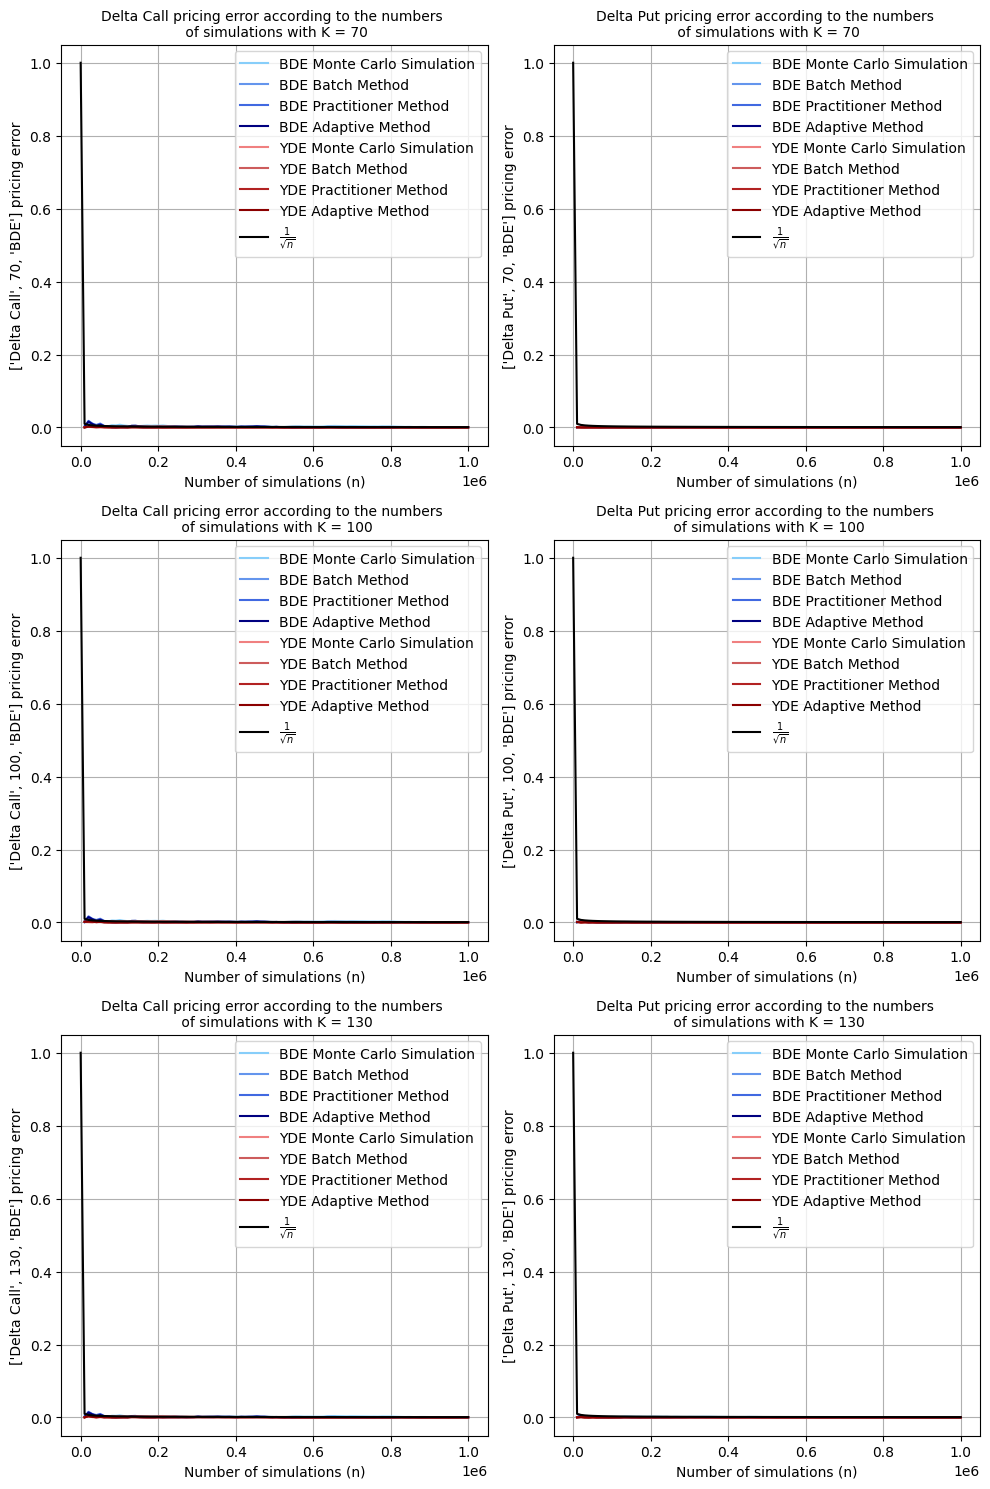

Time 1,000,000 prices generation: 0.04 seconds
Time computation estimators series for each K and each payoff function: 19.87 seconds
Time plot : 1.84 seconds
Total execution time for a total serie of 4,800 Monte Carlo methods: 21.86 seconds


In [426]:
#We plot to compare the CV of each methd and indicators with 1 / sqrt(n)
#We do a first naive version without zooming (the graph will be deformed by the very 
beginning = time.time()  
print_data_convergence_error_according_to_n (S0_CV,r_CV,sigma_CV,T_CV,K_CV,n_CV, estimator_function_CV,option_type_CV,payoff_function_CV, nb_simu_wanted, zoom = 0)
end = time.time() 
execution_time = end - beginning
print(f"Total execution time for a total serie of {16*len(K_CV)*nb_simu_wanted:,} Monte Carlo methods: {execution_time:.2f} seconds")

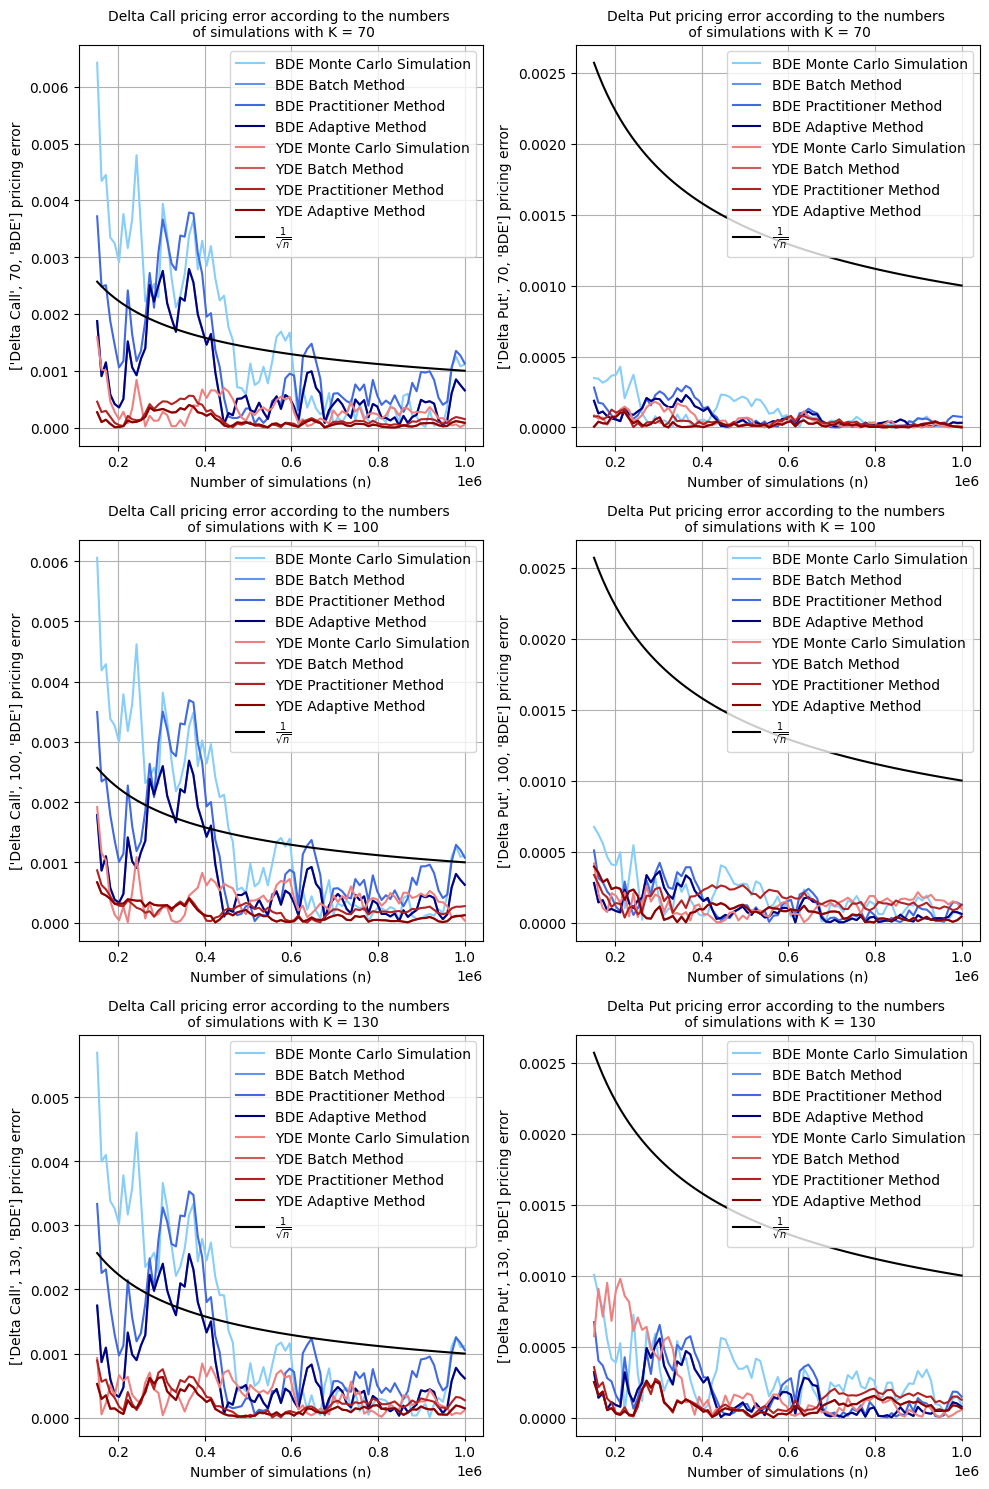

Time 1,000,000 prices generation: 0.06 seconds
Time computation estimators series for each K and each payoff function: 18.81 seconds
Time plot : 1.53 seconds
Total execution time for a total serie of 4,800 Monte Carlo methods: 20.46 seconds


In [427]:
#We do an approach to zoom only on the data on the end of the queue to delete the effect of this fast CV rate near 0
#The MC is done again so it is not the same curves as above
beginning = time.time()  
print_data_convergence_error_according_to_n (S0_CV,r_CV,sigma_CV,T_CV,K_CV,n_CV, estimator_function_CV,option_type_CV,payoff_function_CV, nb_simu_wanted, zoom = 0.15)
end = time.time() 
execution_time = end - beginning
print(f"Total execution time for a total serie of {16*len(K_CV)*nb_simu_wanted:,} Monte Carlo methods: {execution_time:.2f} seconds")


We have the following main characteristics:

- Convergence of the error as the number of simulations convergence to the $O\left( \frac{1}{\sqrt{n}} \right) \to 0 \quad \text{as} \quad n \to \infty$.    
- Better asymptotic convergence for methods using variance reduction compared to the naive Monte Carlo method (test for higher n by reducing points, a bit longer), which exhibits high variance.  
- The curves of the Batch method and the Adaptive method overlap.

  -> This is related to the asymptotic convergence of the results of Batch and Adaptive methods (for k large $\lambda_k \approx \lambda_{k-1}$ et $\tilde\lambda_k = \lambda_k$).

- The convergence happens for both estimators but we still see that the YDE is way better. 

# <div style="font-size: 15px;">3.3 Graphical representation of the differences between BS prices and estimator for several strikes</div>

In [434]:
number_simulations = [50000000]  # Number of simulations
S0_strikes = 100    # Initial price of the underlying asset
r_strikes = 0.05     # Risk-free interest rate
sigma_strikes = 0.2  # Volatility
T_strikes = 8     # Maturity
strikes = [strike for strike in range(80, 125, 5)]  # Strike prices
n_strikes =[1000000, 5000000] # Nb of simulations required
estimator_function_strikes= [b_d_e_simulation,y_d_e_simulation] # Estimator functions
option_type_strikes = [delta_call,delta_put] # Closed formula for our options prices
payoff_function_strikes = [[payoff_call,payoff_put], [derivative_payoff_call,derivative_payoff_put]] # Payoff function

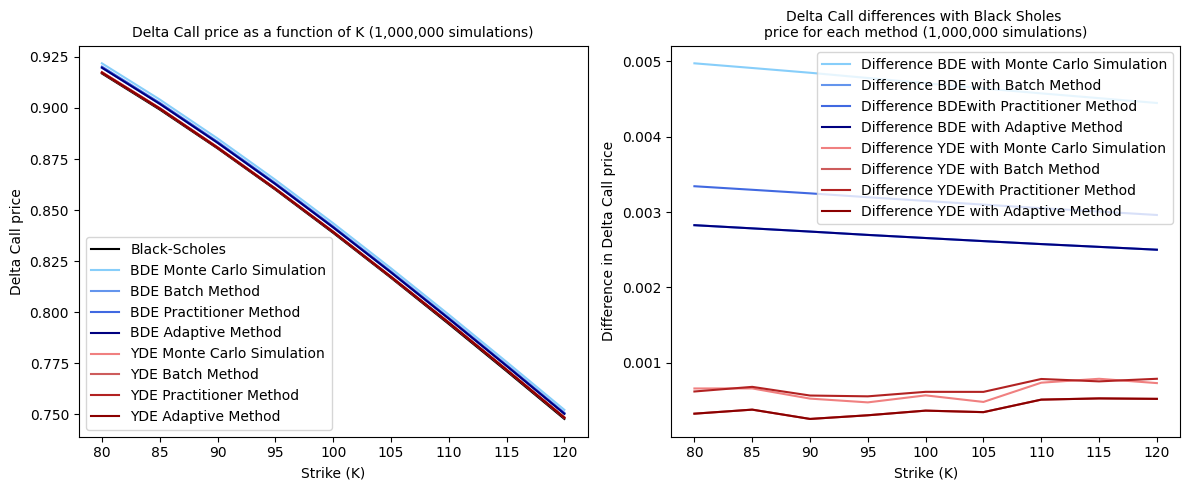

Execution time for n equal to 1,000,000: 1.64 seconds


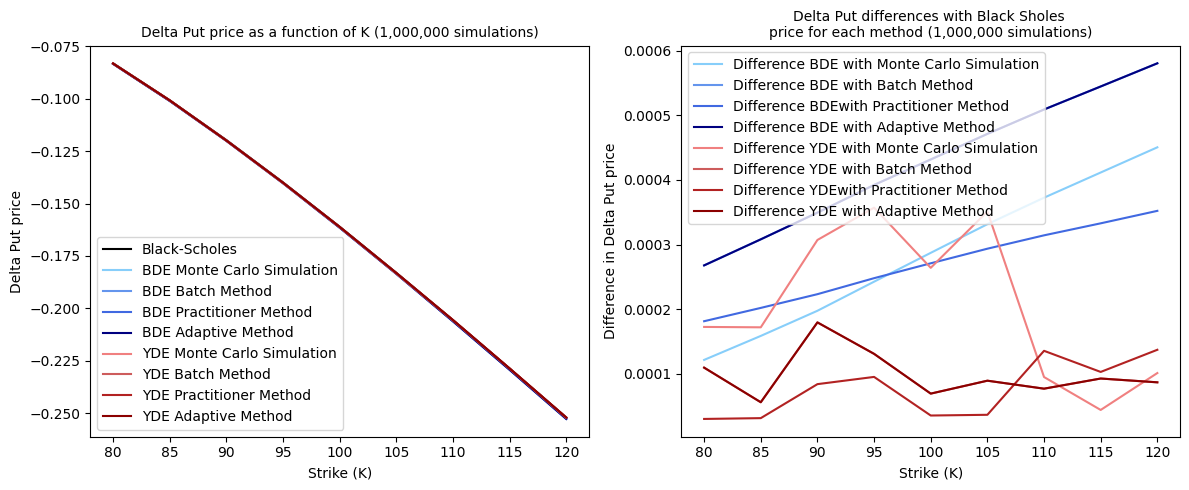

Execution time for n equal to 1,000,000: 3.50 seconds


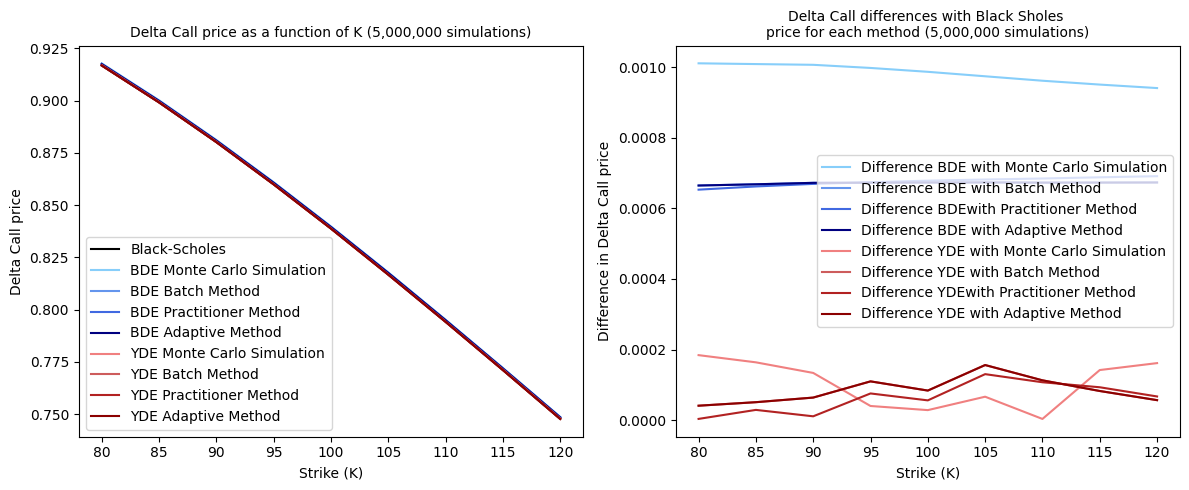

Execution time for n equal to 5,000,000: 9.20 seconds


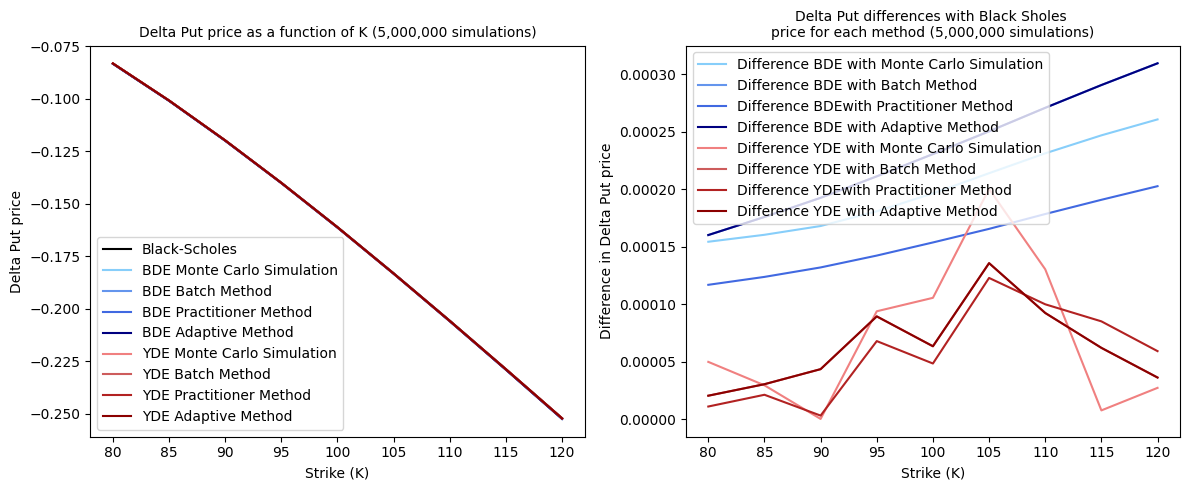

Execution time for n equal to 5,000,000: 14.96 seconds


In [435]:
plot_result (S0_strikes,r_strikes,sigma_strikes,T_strikes,strikes,estimator_function_strikes,n_strikes,option_type_strikes,payoff_function_strikes)


We have the following main characteristics:

- The errors decreases as the number of simulations increases as shown before with YDE better than BDE
- The method using variance reduction methods perform better on an asymptotic perspective and on all the strikes
- According to the nature of our option and if it is way out of the money(call) or in the money (put), our errors increase a little
- Asymptotic convergence of the results of Batch and Adaptive methods (for k large $\lambda_k \approx \lambda_{k-1}$ et $\tilde\lambda_k = \lambda_k$).
- We still get the confirmation of the better quality of the estimator YDE over the estimator BDE